In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
import requests
import optuna
import shap
import joblib
import yaml

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from typing import Dict
from dateutil.parser import parse
from scipy import stats
from optuna.visualization import plot_optimization_history

# 1. Описание задачи

Есть данные по количеству транзакций для одной АЗС за 2021-2023 года в разрезе дней и часов. Необходима модель для прогнозирования количества транзакций/клиентов на дату по часам для построения графиков персонала под поток покупателей. Вывод оптимального количества сотрудников под трафик позволит увеличить продажи и сократить затраты на персонал.  
*Задача регрессии*.  
*Целевая переменная*: count_order  
*Источник данных праздничных, предпраздничных, нерабочих дней*: https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/calendar.json  
**Признаки:**  
- date - дата  
- hour - час  
- holidays - выходной/праздничный день  
- preholidays - предвыходной/предпраздничный день  
- nowork - нерабочий день  
- year - год  
- month - месяц
- day - день месяца
- day_name - день недели
- period_day - период дня:
  1. hours_night - ночь  
  2. hours_morning - утро
  3. hours_day - день
  4. hours_evening - вечер
- season - сезон года:
  1. winter - зима
  2. spring - весна
  3. summer - лето
  4. autumn - осень  

# 2. EDA

In [3]:
params = yaml.load(open('../config/params.yml'), Loader=yaml.FullLoader)

In [23]:
df = pd.read_csv(params['preprocessing']['train_path'], parse_dates=['date'])

In [24]:
def uniq_features(
        data: pd.DataFrame, drop_col: list, target_col: str, uniq_features_path: str) -> None:
        """
        Функция для сохранение словаря с признаками и уникальными значениями
        :param data: подаваемый датафрейм
        :param drop_col: список с названиями признаков для удаления
        :param target_col: целевая переменная
        :param uniq_features_path: путь для сохранения
        :return: None
        """
        unique_df = data.drop(
            columns=drop_col + [target_col], axis=1, errors="ignore"
        )
        dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
        with open(uniq_features_path, "w") as file:
            json.dump(dict_unique, file)

In [25]:
uniq_features(
    data=df,
    drop_col=params['preprocessing']['drop_columns'],
    target_col=params['train']['target_column'],
    uniq_features_path=params['preprocessing']['uniq_features_path'],
)

In [26]:
# добавление признаков праздничный, предпраздничный, нерабочий день
# js = json.loads(requests.get(params['preprocessing']['holidays_calendar_2']).text)
js = json.load(open(params['preprocessing']["holidays_calendar"]))
for x in js:
    df[x] = df['date'].isin(pd.to_datetime(pd.DataFrame(js[x], columns=['date']).date, format="%Y-%m-%d"))

In [27]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_name'] = df.date.dt.day_name()

In [28]:
def map_values(data: pd.DataFrame, map_columns: dict) -> pd.DataFrame:
        """
        функция для замены значений в колонках
        :param data: подаваемый DataFrame
        :param map_columns: словарь с заменяемыми значениями
        :return: датафрейм
        """
        return data.replace(map_columns)

In [29]:
def astype_col(data: pd.DataFrame, map_type_columns: dict) -> pd.DataFrame:
        """
        функция для замены типов данных в колонках
        :param data: подаваемый DataFrame
        :param map_type_columns: словарь с колонками и типом данных
        :return: датафрейм
        """
        return data.astype(map_type_columns)

In [5]:
params['preprocessing']['map_type_col']

{'holidays': 'int', 'preholidays': 'int', 'nowork': 'int'}

In [30]:
map_values(df, params['preprocessing']['map_col'])

,date,hour,count_order,holidays,preholidays,nowork,year,month,day,day_name
0,2021-01-01,0,23,True,False,False,2021,January,1,Friday
1,2021-01-01,1,18,True,False,False,2021,January,1,Friday
2,2021-01-01,2,12,True,False,False,2021,January,1,Friday
3,2021-01-01,3,14,True,False,False,2021,January,1,Friday
4,2021-01-01,4,9,True,False,False,2021,January,1,Friday
...,...,...,...,...,...,...,...,...,...,...
25486,2023-11-30,19,77,False,False,False,2023,November,30,Thursday
25487,2023-11-30,20,73,False,False,False,2023,November,30,Thursday
25488,2023-11-30,21,61,False,False,False,2023,November,30,Thursday
25489,2023-11-30,22,69,False,False,False,2023,November,30,Thursday


In [11]:
df = map_values(df, params['preprocessing']['map_col'])
df = astype_col(df, params['preprocessing']['map_type_col'])

In [12]:
df['period_day'] = df.hour.map(params['preprocessing']['period_day'])
df['season'] = df.month.map(params['preprocessing']['season'])

In [13]:
df.describe().round()

,date,hour,count_order,holidays,preholidays,nowork,year,day
count,25491,25491.0,25491.0,25491.0,25491.0,25491.0,25491.0,25491.0
mean,2022-06-16 07:24:17.879251712,11.0,46.0,0.0,0.0,0.0,2022.0,16.0
min,2021-01-01 00:00:00,0.0,1.0,0.0,0.0,0.0,2021.0,1.0
25%,2021-09-23 00:00:00,5.0,23.0,0.0,0.0,0.0,2021.0,8.0
50%,2022-06-16 00:00:00,11.0,52.0,0.0,0.0,0.0,2022.0,16.0
75%,2023-03-10 00:00:00,18.0,66.0,1.0,0.0,0.0,2023.0,23.0
max,2023-11-30 00:00:00,23.0,109.0,1.0,1.0,1.0,2023.0,31.0
std,NaN,7.0,24.0,0.0,0.0,0.0,1.0,9.0


In [14]:
df.describe(include='object')

,month,day_name,period_day,season
count,25491,25491,25491,25491
unique,12,7,4,4
top,August,Saturday,hours_morning,spring
freq,2232,3648,8501,6620


Выводы:  
- пиковый месяц по кол-ву клиентов август
- чаще всего заправляются в субботу
- в течении дня основной поток клиентов приходится на утренние часы  

## 2.1 Гипотезы  
1. спрос с каждым годом увеличивается
2. кол-во влиентов зависит от дня недели
3. в рабочие дни кол-во клиентов больше чем в праздничные и нерабочие дни
4. в предпраздничные дни пик клиентов приходится на вчерние часы
5. кол-во клиентов зависит от времени суток: на ночные часы приходится минимум клиентов, пиковые периоды: утренние и вечерние часы

### 2.1.1 Гипотеза 1  
спрос с каждым годом увеличивается

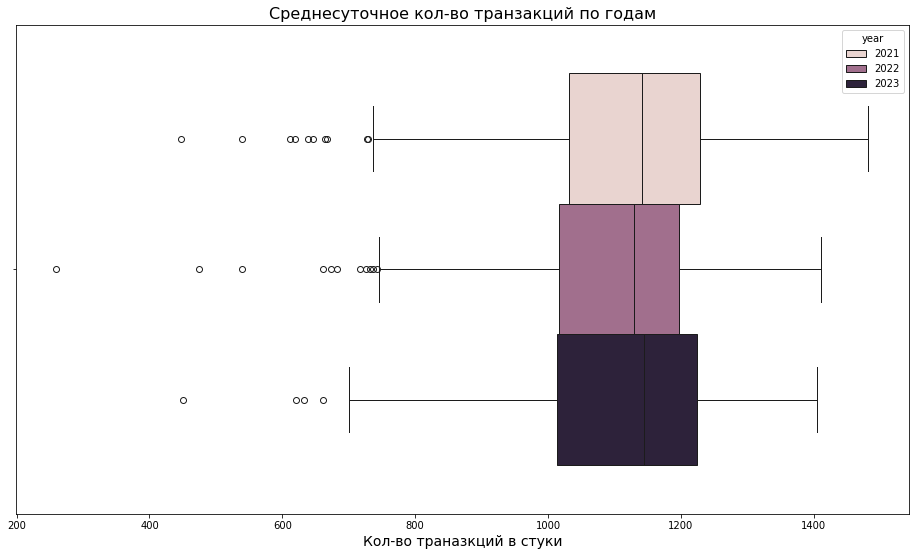

In [15]:
plt.figure(figsize=(16, 9))
sns.boxplot(
    data=df.groupby(['year', 'date'], as_index=False).agg({'count_order': 'sum'}),
    x = 'count_order',
    hue = 'year'
)
plt.title('Среднесуточное кол-во транзакций по годам', fontsize=16)
plt.xlabel('Кол-во траназкций в стуки', fontsize=14)
plt.show();

Сильного различия в количестве клиентов за 3 года нет. В 2022 году более низкикие показатели основных статитстик - связано с началом сво и мобилизацией.

### 2.1.2 Гипотеза 2  
кол-во клиентов зависит от дня недели

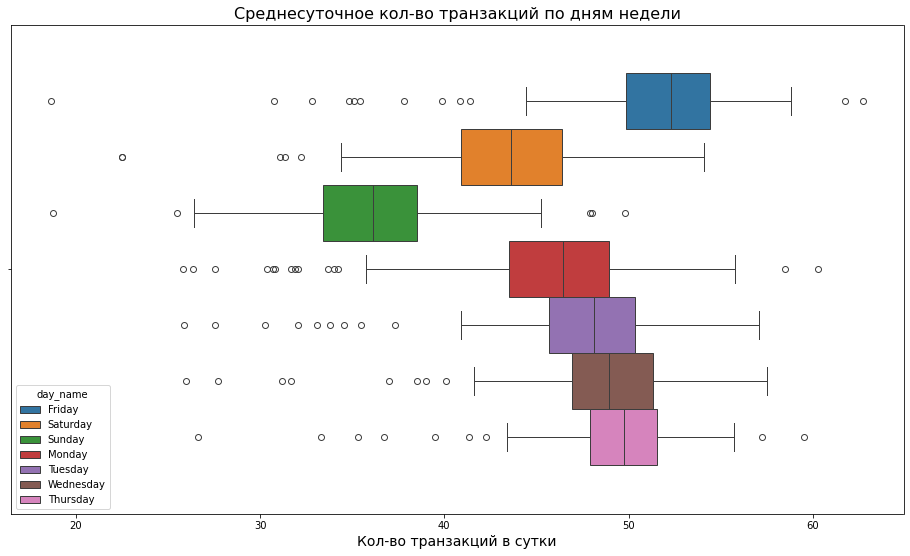

In [16]:
plt.figure(figsize=(16, 9))
sns.boxplot(
    data=df.groupby(['date', 'day_name'], as_index=False).agg({'count_order': 'mean'}),
    x='count_order',
    hue='day_name'
)
plt.xlabel('Кол-во транзакций в сутки', fontsize=14)
plt.title('Среднесуточное кол-во транзакций по дням недели', fontsize=16)
plt.show();

Кол-во клиентов зависит от дня недели: пик продаж приходится на пятницу, самые низкие продажи в воскресенье и субботу

### 2.1.3 Гипотеза 3  
в рабочие дни кол-во клиентов больше чем в праздничные и нерабочие дни

In [17]:
df['work'] = df.iloc[:, 3:6].sum(axis=1)*-1+1

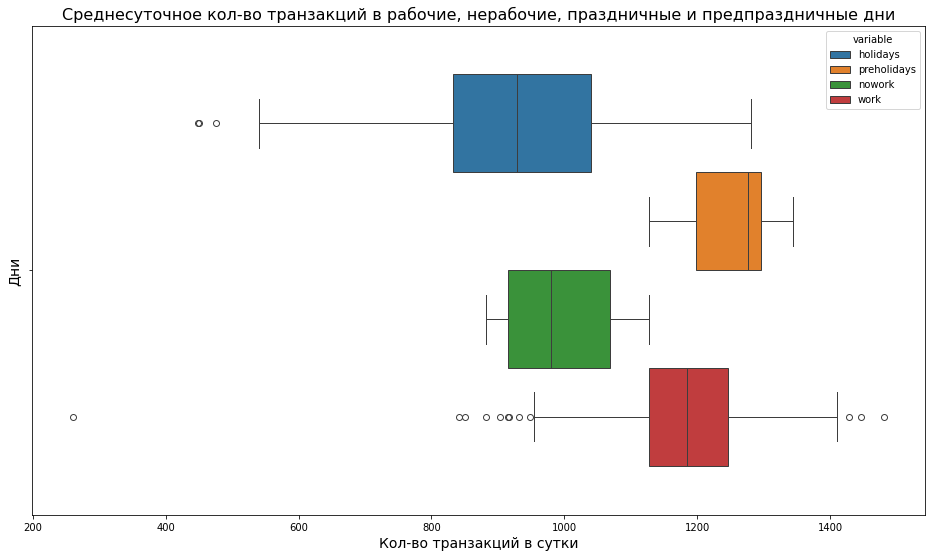

In [19]:
plt.figure(figsize=(16, 9))
sns.boxplot(
    data=pd.melt(df.groupby(['date', 'year', 'holidays', 'preholidays', 'nowork', 'work'], as_index=False) \
    .agg({'count_order': 'sum'}), id_vars=['year', 'date', 'count_order']) \
    .query('value == 1'),
    x='count_order',
    hue='variable'
)
plt.xlabel('Кол-во транзакций в сутки', fontsize=14)
plt.ylabel('Дни', fontsize=14)
plt.title('Среднесуточное кол-во транзакций в рабочие, нерабочие, праздничные и предпраздничные дни', fontsize=16)
plt.show();

Больше всего клиентов АЗС обслуживает в предпраздничные и рабочие дние. В праздничные и нерабочие дни клиентский поток снижается.

### 2.1.4 Гипотеза 4  
в предпраздничные дни пик клиентов приходится на вечерние часы

In [34]:
df.head(2)

,date,hour,count_order,holidays,preholidays,nowork,year,month,day,day_name,period_day,season,work
0,2021-01-01,0,23,1,0,0,2021,January,1,Friday,hours_night,winter,0
1,2021-01-01,1,18,1,0,0,2021,January,1,Friday,hours_night,winter,0


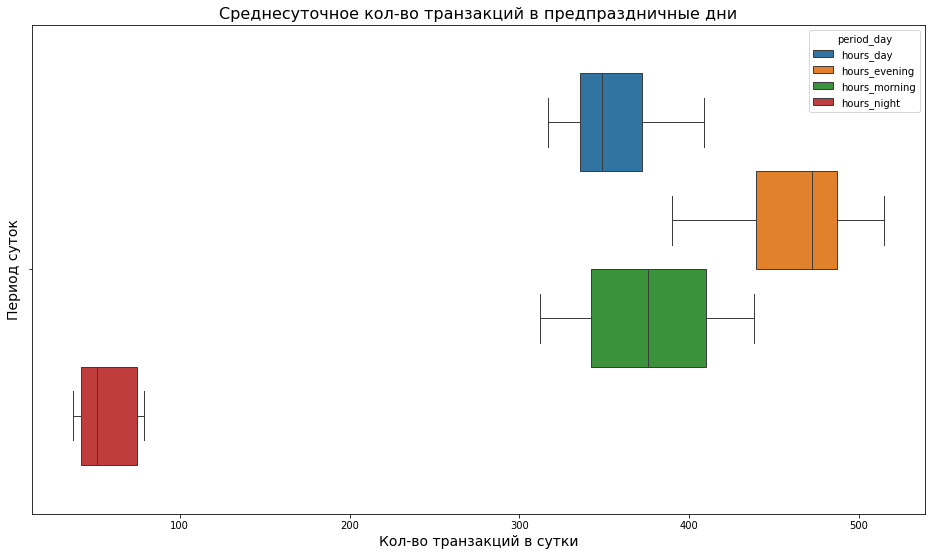

In [20]:
plt.figure(figsize=(16, 9))
sns.boxplot(
    data=df \
    .query('preholidays == 1') \
    .groupby(['year', 'date', 'period_day'], as_index=False) \
    .agg({'count_order': 'sum'}),
    x='count_order',
    hue='period_day'
)
plt.xlabel('Кол-во транзакций в сутки', fontsize=14)
plt.ylabel('Период суток', fontsize=14)
plt.title('Среднесуточное кол-во транзакций в предпраздничные дни', fontsize=16)
plt.show();

В предпраздничные дни основной поток клиентов приходится на вечерние часы

### 2.1.5 Гипотеза 5  
кол-во клиентов зависит от времени суток: на ночные часы приходится минимум клиентов, пиковые периоды: утренние и вечерние часы

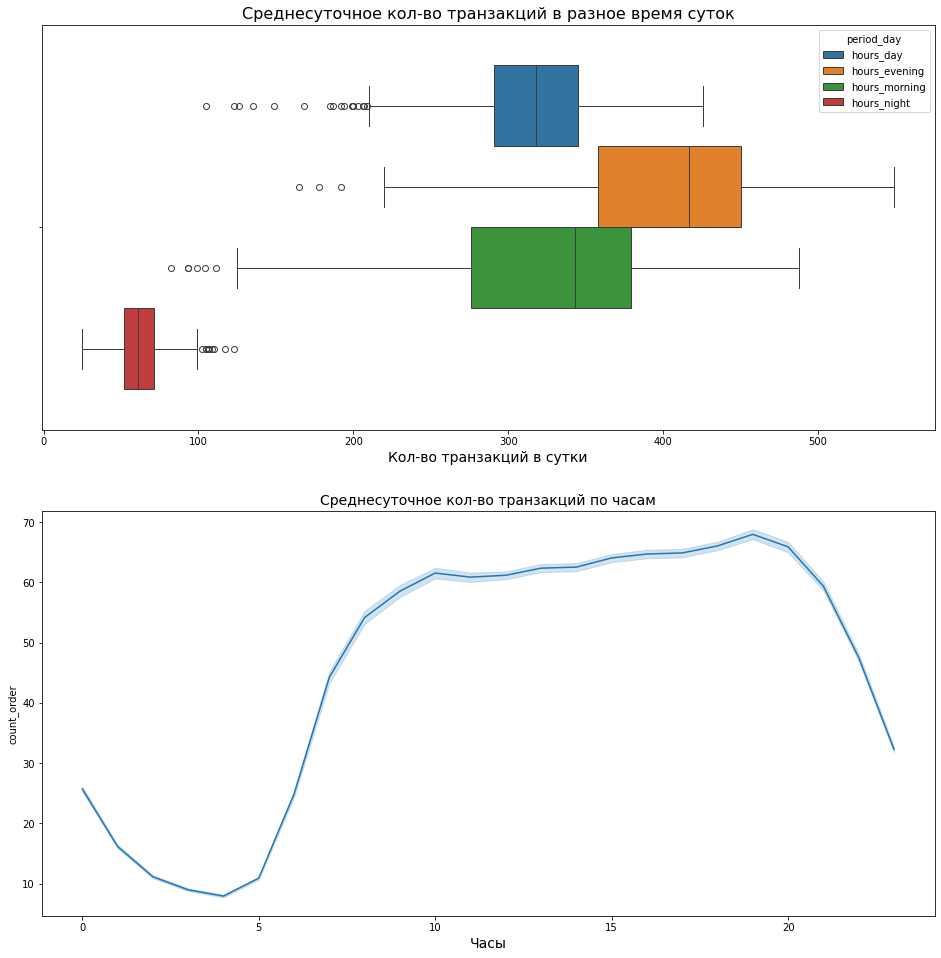

In [36]:
plt.figure(figsize=(16, 9))
plt.subplot(2,1,1)
sns.boxplot(
    data=df \
    .groupby(['date', 'period_day'], as_index=False) \
    .agg({'count_order': 'sum'}),
    x='count_order',
    hue='period_day'
)
plt.xlabel('Кол-во транзакций в сутки', fontsize=14)
plt.title('Среднесуточное кол-во транзакций в разное время суток', fontsize=16)
plt.subplot(2,1,2)
sns.lineplot(
    data=df,
    x='hour',
    y='count_order'
)
plt.xlabel('Часы', fontsize=14)
plt.title('Среднесуточное кол-во транзакций по часам', fontsize=14)
plt.subplots_adjust(top= 1.5)
plt.show();

В ночные часы с 0 до 4 утра минимальное кол-во клиентов, в вечерние часы. Пик продаж приходится на вечерние часы.

## 2.2 Анализ линейной зависимости

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25491 entries, 0 to 25490
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         25491 non-null  datetime64[ns]
 1   hour         25491 non-null  int64         
 2   count_order  25491 non-null  int64         
 3   holidays     25491 non-null  int32         
 4   preholidays  25491 non-null  int32         
 5   nowork       25491 non-null  int32         
 6   year         25491 non-null  int32         
 7   month        25491 non-null  object        
 8   day          25491 non-null  int32         
 9   day_name     25491 non-null  object        
 10  period_day   25491 non-null  object        
 11  season       25491 non-null  object        
 12  work         25491 non-null  int64         
dtypes: datetime64[ns](1), int32(5), int64(3), object(4)
memory usage: 2.0+ MB


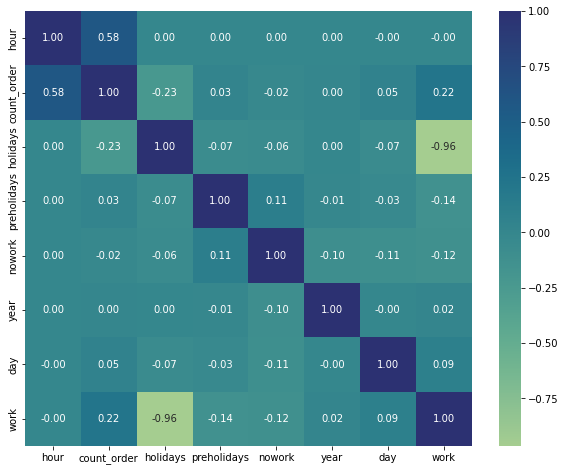

In [38]:
features = ['hour', 'count_order', 'holidays', 'preholidays', 'nowork', 'year', 'day', 'work']
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(method='spearman'), annot=True, fmt='.2f', cmap="crest")
plt.show();

1. Между целевой переменной и признаками отсутствует линейная зависимость
2. Обратная линейная зависимость между выходными и рабочими днями

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25491 entries, 0 to 25490
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         25491 non-null  datetime64[ns]
 1   hour         25491 non-null  int64         
 2   count_order  25491 non-null  int64         
 3   holidays     25491 non-null  int32         
 4   preholidays  25491 non-null  int32         
 5   nowork       25491 non-null  int32         
 6   year         25491 non-null  int32         
 7   month        25491 non-null  object        
 8   day          25491 non-null  int32         
 9   day_name     25491 non-null  object        
 10  period_day   25491 non-null  object        
 11  season       25491 non-null  object        
 12  work         25491 non-null  int64         
dtypes: datetime64[ns](1), int32(5), int64(3), object(4)
memory usage: 2.0+ MB


изменение типа данных с object на category

In [40]:
df.to_csv(params['preprocessing']['path_proc'], index=False)